# Data Preparation

In [155]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt

data_path = 'data.csv'
data = pd.read_csv(data_path)

data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

data.fillna(method='ffill', inplace=True)
data.fillna(method='bfill', inplace=True) 

X = data[['day_of_week', 'month_of_year', 'exp_smoothed', 'holiday', 'day_of_month']]
y = data['ggr']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


# Time Series Cross-Validation

In [152]:
from sklearn.model_selection import TimeSeriesSplit

# Initialize time series cross-validator
tscv = TimeSeriesSplit(n_splits=5)

model = XGBRegressor(objective='reg:squarederror', n_estimators=200, max_depth=4, eta=0.1)

rmse_scores = []
mape_scores = []

for train_index, test_index in tscv.split(X_train):
    X_train_val, X_test_val = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_val, y_test_val = y_train[train_index], y_train[test_index]

    model.fit(X_train_val, y_train_val)
    
    y_pred = model.predict(X_test_val)
    
    fold_rmse = root_mean_squared_error(y_test_val, y_pred)
    fold_mape = mean_absolute_percentage_error(y_test_val, y_pred) * 100
    
    rmse_scores.append(fold_rmse)
    mape_scores.append(fold_mape)

average_nrmse = np.mean(rmse_scores / (data['ggr'].max() - data['ggr'].min())) 
average_mape = np.mean(mape_scores)

print(f"MAPE on Train Data: {average_mape:.2f}%")
print(f"NRMSE on Train Data: {average_nrmse:.2f}")

MAPE on Train Data: 10.06%
NRMSE on Train Data: 0.07


# Test

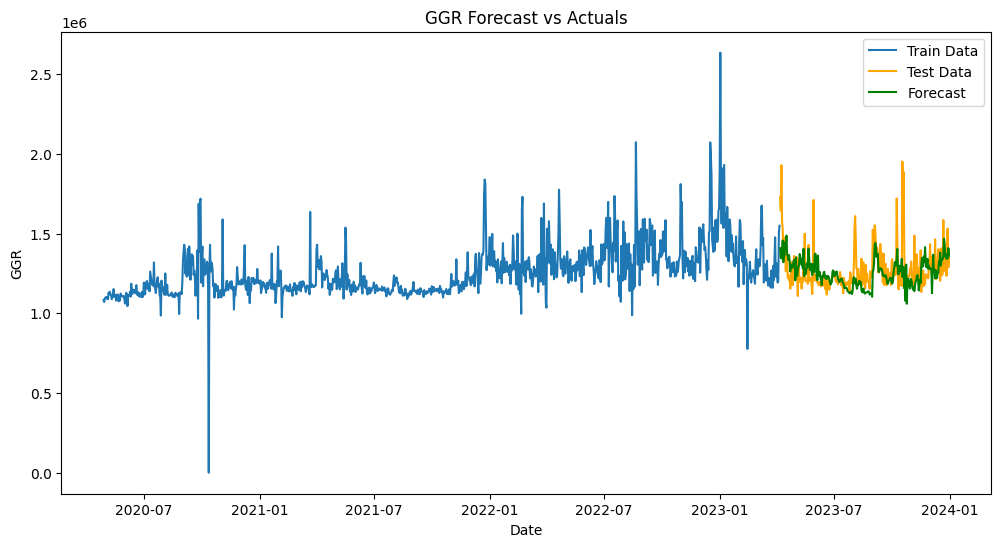

MAPE on Test Data: 6.63%
NRMSE on Test Data: 0.05


In [156]:
model = XGBRegressor(objective='reg:squarederror', n_estimators=200, max_depth=4, eta=0.1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

nrmse_test = root_mean_squared_error(y_test, y_pred) / (data['ggr'].max() - data['ggr'].min())
mape_test = mean_absolute_percentage_error(y_test, y_pred) * 100

plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label='Train Data')
plt.plot(y_test.index, y_test, label='Test Data', color='orange')
plt.plot(y_test.index, y_pred, label='Forecast', color='green')
plt.title('GGR Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('GGR')
plt.legend()
plt.show()

print(f"MAPE on Test Data: {mape_test:.2f}%")
print(f"NRMSE on Test Data: {nrmse_test:.2f}")


In [154]:
import pickle

# Save the model with pickle
with open('xgboost_model.pkl', 'wb') as file:
    pickle.dump(model, file)